# Estimating MI by noise contrastive method (InfoNCE)

## Setup

The following cell imports the necessary packages:

In [1]:
import torch
import torch.nn as nn
import os
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torch.autograd import Variable
import itertools
from tqdm import tqdm
from src.gaussian import Gaussian
from src.mi_estimators import *
from src.mix_gaussian import MixedGaussian
from src.mi_estimators_derangement import *
from torch.utils.tensorboard import SummaryWriter
import datetime

Use GPU if GPU is available.

In [2]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

Set random seed for reproducibility.

In [3]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

Specify the hyper-parameters:

In [4]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=2, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=100, help="sample size")
parser.add_argument("--gamma", type=float, default=0, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--n_iters", type=int, default=3000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=20, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--c_0_1_ratio", type=float, default=1, help="Ratio of samples with label 0 and samples with label 1 ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")

parser.add_argument("--n_epoch", type=int, default=6000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

ma_rate = 0.5  # moving average rate

opt, unknown = parser.parse_known_args()

Specify the distribution to generate the data samples:

In [5]:
# Two choices here: 'Gaussian' and 'MixedGaussian'
density = 'Gaussian'

continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results

## Model

In [6]:
def generate_data(distribution='Gaussian', sample_size=400, rho=0.9):
    # rho is the covariance for generating distributions
    # mu1 and mu2 are means for generating Mixed Gaussian distribution 
    mu1 = 0
    mu2 = 0

    # mg is an object of Class Gaussian or MixedGaussian
    if distribution=='Gaussian':
        mg = Gaussian(sample_size=sample_size,rho=rho)
    else:
        mg = MixedGaussian(sample_size=sample_size, mean1=mu1, mean2=mu2,rho1=rho, rho2=-rho)

    # Calculate the ground truth MI between X and Y for (X, Y) from mg
    mi = mg.ground_truth * opt.d

    # Create X, Y for storing generated samples
    X = np.zeros((sample_size,opt.d))
    Y = np.zeros((sample_size,opt.d))

    # Generate samples of random variable X,Y and XY
    for j in range(opt.d):
        # In each iteration, mg.data will generate samples of two dimensions where one dimension for X and another for Y respectively 
        data = mg.data
        X[:,j] = data[:,0]
        Y[:,j] = data[:,1]        
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    XY = torch.cat((X, Y), dim=1)

    return XY, X, Y, mi

In [8]:
XY, X, Y, Ground_truth = generate_data(distribution=density, sample_size=opt.sample_size, rho=opt.rho)

Define the neural network.

In [9]:
class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)

        return output

The function `_resample` below is for resampling the given data samples for training the neural network.

In [10]:
def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch

The function `infonce_loss` below returns the empirical estimate of the following infoNCE lower bound on the mutual information $I(X\wedge Y)$:

\begin{align}
I_{\text{infoNCE}}(f) := E\left[\log \frac{e^{f(X, Y)}}{E \left[\left. e^{f( X, Y')} \right| X \right]} \right] \leq I(X\wedge Y) 
\end{align}

where $f: \mathcal{X}\times \mathcal{Y}\to \mathbb{R}$ is a function to be implemented by a neural network, and $p_{Y'|X,Y}(y'|x,y)=p_{Y}(y)$, i.e., $Y'$ is identically distributed as $Y$ and independent of $(X,Y)$.


In [11]:
def infonce_loss(net, x_samples, y_samples):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))

    lower_bound = T0.mean() - (T1.logsumexp(dim = 1).mean() - np.log(sample_size))
    return lower_bound

The neural network `discriminator` below implements $f$:

In [95]:
name = f'./results/InfoNCE_dim{opt.d}'   # filename
chkpt_name = name+'.pt'      # checkpoint
writer = SummaryWriter(f'./results/log/InfoNCE_dim{opt.d}')

discriminator = Net(input_size=opt.d*2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Load previous results.

In [96]:
# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

Previous results loaded.


## Training

Since maximizing the infoNCE bound over $f$ attains the mutual information

\begin{align}
I(X\wedge Y) = \sup_{f} I_{\text{infoNCE}}(f),
\end{align}

we train the neural network to minimize the loss $-I_{\text{infoNCE}}(f)$. The optimal solution $f$ satisfies

\begin{align}
f(x,y)=\log \frac{p_{Y|X}(y|x)}{p_{Y}(y)} + c \quad \forall x\in \mathcal{X}, y \in \mathcal{Y}
\end{align}

for any constant $c$.

The following cell train the neural network using the data samples.

In [97]:
# continue_train = False  # set to True to continue to train
if continue_train:
    for i in range(opt.n_epoch*opt.n_iters_1epoch):
        data_joint = _resample(XY, batch_size=opt.batch_size)
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]

        optimizer_D.zero_grad()
        loss = - infonce_loss(discriminator, train_x, train_y) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            mi_est = infonce_loss(discriminator, X, Y)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)
        if i%500==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))

writer.add_graph(discriminator, (XY,))

In [98]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


## MI estimates

Use moving average to smooth the estimated MI in each training iteration.

In [99]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

Plot the MI estimation curve against the training iteration, together with the ground truth.

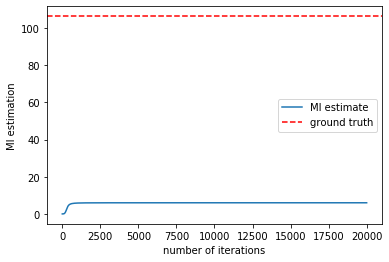

In [100]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()

Save the model.

In [101]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'mi_copy': mi_copy,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


## InfoNCE w\o datasamples

In [12]:
discriminator2 = Net(input_size=opt.d*2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator2.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator2.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [13]:
def estimate(Net, X, Y):
    n = X.shape[0]
    idx = torch.arange(n)
    MI_estimate = (Net(torch.cat((X, Y),dim=1)).mean() - sum([Net(torch.cat((X[[i]].repeat_interleave(n - 1, dim=0), Y[idx != i]),dim=1)).logsumexp(0) for i in range(n)
            ]) / n + np.log(n - 1)).item()
    return MI_estimate

In [14]:
name = f'./results/InfoNCE_derangement_dim{opt.d}'   # filename
chkpt_name = name+'.pt'      # checkpoint
writer = SummaryWriter(f'./results/log/InfoNCE_derangement_dim{opt.d}')


# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator2.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [15]:
# continue_train = True  # set to True to continue to train
_iter = 0
if continue_train:
    for i in range(opt.n_epoch):
        idx = torch.randperm(opt.sample_size)

        for j in range(opt.n_iters_1epoch):
            optimizer_D.zero_grad()
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_X = X[batch_idx]
            batch_Y = Y[batch_idx]
            batch_ref_idx = torch.cat([
                idx[(j + k) % opt.n_iters_1epoch::opt.n_iters_1epoch]
                for k in range(1, opt.n_iters_1epoch)
            ])
            batch_X_ref = X[batch_idx.unsqueeze(0).repeat(
                batch_ref_idx.shape[0], 1)]
            batch_Y_ref = Y[batch_ref_idx.unsqueeze(1).repeat(
                1, batch_idx.shape[0])]

            # define the loss
            L = -discriminator2(torch.cat((batch_X, batch_Y),dim=1)).mean()
            L_ = discriminator2(torch.cat
                ((batch_X_ref.reshape((-1,) + batch_X_ref.shape[2:]),
                batch_Y_ref.reshape((-1,) + batch_Y_ref.shape[2:])), dim=1)).reshape(
                    (batch_ref_idx.shape[0], batch_idx.shape[0],
                        -1)).logsumexp(1) - np.log(batch_ref_idx.shape[0])
            loss = L + L_.mean()
            loss.backward()

            optimizer_D.step()
            writer.add_scalar("Loss/train",
                                    loss.item(),
                                    global_step=_iter)
            writer.add_scalar("L", L.item(), global_step=_iter)
            writer.add_scalar("L_.mean()",
                                    L_.mean().item(),
                                    global_step=_iter)
            _iter += 1

            with torch.no_grad():
                mi_est = estimate(discriminator2, X, Y)
            
            mi_list.append(mi_est)
            writer.add_scalar('mi_list', mi_est, _iter)
            writer.add_scalar('loss', loss, _iter)
            if _iter%500==0:
                print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))
                
writer.add_graph(discriminator2, (XY,))

Iternation: 500, loss: -12.386161, mi_est: -2.415459
Iternation: 1000, loss: -93.435318, mi_est: -49.025822
Iternation: 1500, loss: -238.683655, mi_est: -154.904816
Iternation: 2000, loss: -541.035522, mi_est: -343.210449
Iternation: 2500, loss: -1015.704407, mi_est: -639.354004
Iternation: 3000, loss: -1455.180054, mi_est: -1067.091064
Iternation: 3500, loss: -1464.354736, mi_est: -1614.104858
Iternation: 4000, loss: -3175.569580, mi_est: -2221.520020
Iternation: 4500, loss: -3339.726562, mi_est: -2986.965088
Iternation: 5000, loss: -5341.647949, mi_est: -3919.909424
Iternation: 5500, loss: -6871.852051, mi_est: -5001.102051
Iternation: 6000, loss: -8350.160156, mi_est: -6266.578613
Iternation: 6500, loss: -7571.367188, mi_est: -7675.131836
Iternation: 7000, loss: -13230.638672, mi_est: -9250.400391
Iternation: 7500, loss: -15153.259766, mi_est: -10995.807617
Iternation: 8000, loss: -18651.566406, mi_est: -12900.179688
Iternation: 8500, loss: -20287.218750, mi_est: -14999.442383
Itern

In [106]:
mi_copy2 = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy2[k] = (1-ma_rate) * mi_copy2[k-1] + ma_rate * mi_copy2[k]

In [107]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator2.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


## InfoNCE with GT reference distribution

In [108]:
discriminator3 = Net(input_size=opt.d*2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator3.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator3.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [109]:
name = f'./results/InfoNCE_knownref_dim{opt.d}'   # filename
chkpt_name = name+'.pt'      # checkpoint
writer = SummaryWriter(f'./results/log/InfoNCE_knownref_dim{opt.d}')


# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator3.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

Previous results loaded.


In [110]:
def estimate_withGT(Net, jointdata, marginaldata):
    L = Net(jointdata).mean()
    L_ = discriminator3(marginaldata).reshape((jointdata.shape[0], jointdata.shape[0], -1)).logsumexp(1) - np.log(jointdata.shape[0])
    return L - L_.mean()

In [111]:
idx = torch.randperm(opt.sample_size)
_, _, ref_Y, _ = generate_data(distribution=density, sample_size=opt.sample_size**2, rho=opt.rho)
ref_X = X.repeat(opt.sample_size, 1)
ref_data = torch.cat((ref_X, ref_Y), dim=1)

# continue_train = True  # set to True to continue to train
_iter = 0
if continue_train:
    for i in range(opt.n_epoch):
        idx = torch.randperm(opt.sample_size)

        for j in range(opt.n_iters_1epoch):
            optimizer_D.zero_grad()
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_X = X[batch_idx]
            batch_Y = Y[batch_idx]

            batch_X_ref = X[batch_idx.unsqueeze(0).repeat(
                opt.sample_size, 1)]
            _, _, batch_Y_ref, _ = generate_data(distribution=density, sample_size=opt.sample_size*batch_idx.shape[0], rho=opt.rho)
            batch_Y_ref = batch_Y_ref.reshape((-1,) + batch_X_ref.shape[1:])
            # define the loss
            L = -discriminator3(torch.cat((batch_X, batch_Y),dim=1)).mean()
            L_ = discriminator3(torch.cat((batch_X_ref, batch_Y_ref), dim=-1)).reshape(
                    (opt.sample_size, batch_idx.shape[0],
                        -1)).logsumexp(1) - np.log(batch_Y_ref.shape[0])
            loss = L + L_.mean()
            loss.backward()

            optimizer_D.step()
            writer.add_scalar("Loss/train",
                                    loss.item(),
                                    global_step=_iter)
            writer.add_scalar("L", L.item(), global_step=_iter)
            writer.add_scalar("L_.mean()",
                                    L_.mean().item(),
                                    global_step=_iter)
            _iter += 1

            with torch.no_grad():
                mi_est = estimate_withGT(discriminator3, XY, ref_data)
            
            mi_list.append(mi_est.item())
            writer.add_scalar('mi_list', mi_est, _iter)
            writer.add_scalar('loss', loss, _iter)
            if _iter%500==0:
                print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))
                
writer.add_graph(discriminator3, (XY,))

In [112]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator3.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


In [113]:

mi_copy3 = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy3[k] = (1-ma_rate) * mi_copy3[k-1] + ma_rate * mi_copy3[k]

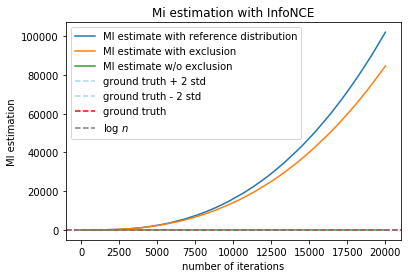

In [114]:
std = 0.183
plt.plot(mi_copy3, label='MI estimate with reference distribution')
plt.plot(mi_copy2, label='MI estimate with exclusion')
plt.plot(mi_copy, label='MI estimate w/o exclusion')

plt.axhline(Ground_truth+2*std,label='ground truth + 2 std',linestyle='--',color='lightblue')
plt.axhline(Ground_truth-2*std,label='ground truth - 2 std',linestyle='--',color='lightblue')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('Mi estimation with InfoNCE')
plt.legend()
plt.savefig(f'results/InfoNCE_wo_datapoints_dim{opt.d}_ma{ma_rate}.pdf')

In [32]:
ma_rate

0.5

In [130]:
def plot_subfigure(net, X, Y, dimX, dimY, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=None, show_details=True):
    """
    The inputs should be X and Y, which are the coordinates of the points.

    net should be a neural network with Tensor inputs.
    """

    if  x0 == None:
        x0 = np.zeros((1, X.shape[1]))
    if y0 == None:
        y0 = np.zeros((1, Y.shape[1]))
        
    x, y = np.mgrid[xmin:xmax:xgrids * 1j, ymin:ymax:ygrids * 1j]
    with torch.no_grad():
        z = (net(
            torch.cat((torch.Tensor((np.arange(X.shape[-1]) == dimX).reshape(1, -1) *
                    x.reshape(-1, 1) + x0).to(DEVICE),
            torch.Tensor((np.arange(X.shape[-1]) == dimY).reshape(1, -1) *
                    y.reshape(-1, 1) + y0).to(DEVICE),
        ),dim=-1)).reshape(x.shape).cpu())
    if ax is None:
        ax = plt.gca()
    # im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto")
    im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto", vmin=-12, vmax=-3)
    # ax.figure.colorbar(im)
    if show_details:
        ax.figure.colorbar(im) 
        ax.set(xlabel="$x^{{({0})}}-x_0^{{({0})}}$",
                ylabel="$x^{{({0})}}-x_0^{{({0})}}$",
                title=r"Heatmap of $t(x,y)$")
    return im

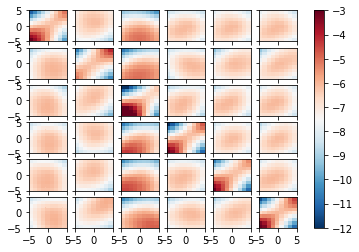

In [131]:
d = 6
# DEVICE = "cuda"
f, axs = plt.subplots(nrows=d,ncols=d, sharex=True, sharey=True)
for i in range(d):
    for j in range(d):
        im = plot_subfigure(discriminator, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=10, ygrids=10, ax=axs[i, j], show_details=False)

f.colorbar(im, ax=axs.ravel().tolist())
plt.savefig(f'results/InfoNCE_heatmap_dim{opt.d}.pdf')
# plt.tight_layout()
plt.show()

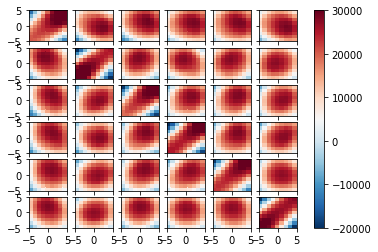

In [129]:
d = 6
DEVICE = "cuda"
f, axs = plt.subplots(nrows=d,ncols=d, sharex=True, sharey=True)
for i in range(d):
    for j in range(d):
        im = plot_subfigure(discriminator2, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=10, ygrids=10, ax=axs[i, j], show_details=False)
f.colorbar(im, ax=axs.ravel().tolist())
plt.savefig(f'results/InfoNCE_nodatapoint_heatmap_dim{opt.d}.pdf')
plt.show()

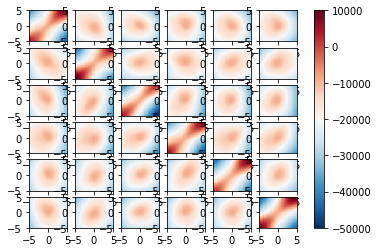

In [54]:
d = 6
DEVICE = "cuda"
f, axs = plt.subplots(nrows=d,ncols=d)
for i in range(d):
    for j in range(d):
        im = plot_subfigure(discriminator3, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)
f.colorbar(im, ax=axs.ravel().tolist())
plt.savefig(f'results/InfoNCE_trueref_heatmap_dim{opt.d}.pdf')
plt.show()

In [125]:
def plot_subfigure_GT(net, X, Y, dimX, dimY, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=None, show_details=True):
    """
    net: GT_logratio
    """
    if  x0 == None:
        x0 = np.zeros((1, X.shape[1]))
    if y0 == None:
        y0 = np.zeros((1, Y.shape[1]))
        
    x, y = np.mgrid[xmin:xmax:xgrids * 1j, ymin:ymax:ygrids * 1j]
    with torch.no_grad():
        z = (net(
            torch.Tensor((np.arange(X.shape[-1]) == dimX).reshape(1, -1) *
                    x.reshape(-1, 1) + x0).to(DEVICE),
            torch.Tensor((np.arange(X.shape[-1]) == dimY).reshape(1, -1) *
                    y.reshape(-1, 1) + y0).to(DEVICE),
        ).reshape(x.shape).cpu())
    if ax is None:
        ax = plt.gca()
    im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto", vmax=150, vmin=-100)
    if show_details:
        ax.figure.colorbar(im) 
        ax.set(xlabel="$x^{{({0})}}-x_0^{{({0})}}$",
                ylabel="$x^{{({0})}}-x_0^{{({0})}}$",
                title=r"Heatmap of $t(x,y)$")

    return im

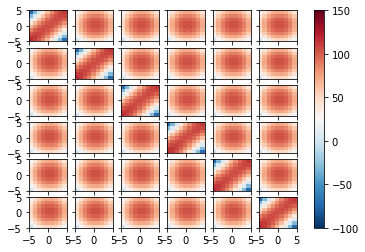

In [132]:
d = 6
DEVICE = "cuda"
f, axs = plt.subplots(nrows=d,ncols=d,sharex=True, sharey=True)
for i in range(d):
    for j in range(d):
        im = plot_subfigure_GT(GT_logratio, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=10, ygrids=10, ax=axs[i, j], show_details=False)

# plt.savefig(f'results/InfoNCE_trueref_heatmap_dim{opt.d}.pdf')
# im = plot_subfigure_GT(GT_logratio, X, Y, dimX=4, dimY=5, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)
f.colorbar(im, ax=axs.ravel().tolist())
plt.savefig(f'results/GT_heatmap_dim{opt.d}.pdf')
plt.show()

In [ ]:
# add gt reference
# add sigma  2std
# PCM + exclusion
# add regularization
# check the gradient, why exponential function
# smoothing factor

## Calculate the MI estimation with Ground Truth

In [58]:
from scipy.stats import multivariate_normal

rv1 = multivariate_normal([0,0], [[1, opt.rho], [opt.rho, 1]])
rv2 = multivariate_normal([0,0], [[1, 0], [0, 1]])

def GT_logratio(x, y):
    logprobratio = np.zeros(x.shape[0])
    for j in range(x.shape[1]):
        sub_XY = torch.cat((x[:,j].reshape(x.shape[0],1),y[:,j].reshape(y.shape[0],1)), dim=1).cpu().numpy()
        logprobratio += np.log((rv1.pdf(sub_XY)/rv2.pdf(sub_XY)))
    return torch.Tensor(logprobratio)

In [ ]:
opt.sample_size = 400
opt.d = 20
XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)

In [75]:
def GT(rho, d, x, y):
    mi = -0.5 * np.log(1 - rho**2) * d
    c = rho / (2 * (1 - rho**2))
    return mi + c * (2 * x * y - rho *(x**2 + y**2)).sum(dim=1)


In [ ]:
mi_ = []
for i in range(100):
    XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)
    mi_.append(GT_logratio(X, Y).mean().item())

np.std(mi_)

0.21665217447681628

## InfoNCE

In [ ]:
# Compute the MI with Ground truth (with exclusion)) ; InfoNCE
idx = torch.arange(opt.sample_size)
(GT_logratio(X, Y).mean() - sum([GT_logratio(X[[i]].repeat_interleave(opt.sample_size - 1, dim=0),Y[idx != i]).logsumexp(0) for i in range(opt.sample_size)]) / opt.sample_size + np.log(opt.sample_size - 1)).item()

31.482677459716797

In [ ]:
# Compute the MI with Ground truth (without exclusion)) ; InfoNCE
idx = torch.arange(opt.sample_size)
(GT_logratio(X, Y).mean() - sum([GT_logratio(X[[i]].repeat_interleave(opt.sample_size, dim=0),Y[idx]).logsumexp(0) for i in range(opt.sample_size)]) / opt.sample_size + np.log(opt.sample_size)).item()

5.991168975830078

In [ ]:
opt.sample_size = 400
opt.d = 20
XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)

In [ ]:
Ground_truth

16.607312068216512

## MINE

In [ ]:
# Compute the MI with Ground truth (without exclusion)) ; MINE
idx = torch.arange(opt.sample_size)
marginal_X = torch.Tensor()
marginal_Y = torch.Tensor()
for i in range(opt.sample_size):
    marginal_X = torch.cat((marginal_X, X[[i]].repeat_interleave(opt.sample_size, dim=0)), dim=0)
    marginal_Y = torch.cat((marginal_Y, Y[idx]), dim=0)

(GT_logratio(X, Y).mean() - torch.logsumexp(GT_logratio(marginal_X, marginal_Y), dim=0) + 2*np.log(opt.sample_size)).item()

-2.376943588256836

In [ ]:
# Compute the MI with Ground truth (with exclusion)) ; MINE
idx = torch.arange(opt.sample_size)
marginal_X = torch.Tensor()
marginal_Y = torch.Tensor()
for i in range(opt.sample_size):
    marginal_X = torch.cat((marginal_X, X[[i]].repeat_interleave(opt.sample_size-1, dim=0)), dim=0)
    marginal_Y = torch.cat((marginal_Y, Y[idx!=i]), dim=0)

(GT_logratio(X, Y).mean() - torch.logsumexp(GT_logratio(marginal_X, marginal_Y), dim=0) + np.log(opt.sample_size*(opt.sample_size-1))).item()

19.132158279418945

## NWJ

In [ ]:
# Compute the MI with Ground truth (without exclusion)) ; NWJ
idx = torch.arange(opt.sample_size)
marginal_X = torch.Tensor()
marginal_Y = torch.Tensor()
for i in range(opt.sample_size):
    marginal_X = torch.cat((marginal_X, X[[i]].repeat_interleave(opt.sample_size, dim=0)), dim=0)
    marginal_Y = torch.cat((marginal_Y, Y[idx]), dim=0)


GT_logratio(X, Y).mean() - torch.exp(GT_logratio(marginal_X, marginal_Y)-1).mean()

tensor(-49464216.)

In [ ]:
# Compute the MI with Ground truth (with exclusion)) ; MINE
idx = torch.arange(opt.sample_size)
marginal_X = torch.Tensor()
marginal_Y = torch.Tensor()
for i in range(opt.sample_size):
    marginal_X = torch.cat((marginal_X, X[[i]].repeat_interleave(opt.sample_size-1, dim=0)), dim=0)
    marginal_Y = torch.cat((marginal_Y, Y[idx!=i]), dim=0)

GT_logratio(X, Y).mean() - torch.exp(GT_logratio(marginal_X, marginal_Y)-1).mean()

tensor(16.3173)

In [16]:
a = torch.Tensor([[1,2],[3,4]])

In [17]:
b = torch.Tensor([[5,5],[6,6]])

In [18]:
x_tile = a.unsqueeze(0).repeat((a.shape[0], 1, 1))
y_tile = b.unsqueeze(1).repeat((1, b.shape[0], 1))
train_data = torch.cat([x_tile, y_tile], dim = -1).reshape(-1, b.shape[1]+b.shape[1])

In [19]:
train_data

tensor([[1., 2., 5., 5.],
        [3., 4., 5., 5.],
        [1., 2., 6., 6.],
        [3., 4., 6., 6.]])

In [22]:
diag_mask =  torch.ones([2]).diag().unsqueeze(-1).cuda()
diag_mask.shape

torch.Size([2, 2, 1])

In [24]:
torch.cat([x_tile, y_tile], dim = -1)

tensor([[[1., 2., 5., 5.],
         [3., 4., 5., 5.]],

        [[1., 2., 6., 6.],
         [3., 4., 6., 6.]]])

In [25]:
diag_mask

tensor([[[1.],
         [0.]],

        [[0.],
         [1.]]])

In [26]:
model = Net(input_size=4, hidden_size=4)

In [28]:
output = model(torch.cat([x_tile, y_tile], dim = -1))

In [45]:
diag_mask =  (torch.ones([2])*(-np.inf)).diag().unsqueeze(-1).cuda()

In [47]:
torch.logsumexp(output+diag_mask, dim=1)

tensor([[8.6994e-06],
        [3.3343e-05]], grad_fn=<LogsumexpBackward>)

In [48]:
output

tensor([[[2.5705e-05],
         [8.6994e-06]],

        [[3.3343e-05],
         [1.6346e-05]]], grad_fn=<AddBackward0>)

In [44]:
torch.exp(torch.Tensor([-np.inf]))

tensor([0.])

In [164]:
from src.utils import *

setup_seed(3)

In [12]:
discriminator = Net(input_size=opt.d*2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())

writer = SummaryWriter(f'./results/log/InfoNCE_dim{opt.d}_reg/{TIMESTAMP}')

mi_list = []

In [13]:
def plot_fig(net, d=6):
    DEVICE = "cuda"
    f, axs = plt.subplots(nrows=d,ncols=d,sharex=True, sharey=True)
    for i in range(d):
        for j in range(d):
            im = plot_subfigure(net, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)
    f.colorbar(im, ax=axs.ravel().tolist())
    return f

In [14]:
def infonce_exc_loss(net, x_samples, y_samples, writer=None, epoch=None):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))
    mask =  torch.ones([sample_size]).diag().unsqueeze(-1).bool().cuda()
    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))
    a = T0.mean()
    b = T1[~mask].reshape(-1, sample_size-1, 1).logsumexp(dim = 0).mean() - np.log(sample_size-1)
    lower_bound = a - b

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)
    return lower_bound

In [15]:
def infonce_loss(net, x_samples, y_samples, writer=None, epoch=None, reg=False):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))
    a = T0.mean()
    b = T1.logsumexp(dim = 1).mean() - np.log(sample_size)
    if reg:
        lower_bound = a - b - b**2
    else:
        lower_bound = a - b

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)
        writer.add_scalar('log ratio', a-b-np.log(sample_size), epoch)
    return lower_bound

In [16]:
continue_train = True  # set to True to continue to train
if continue_train:
    for i in range(opt.n_epoch*opt.n_iters_1epoch):
        data_joint = _resample(XY, batch_size=opt.batch_size)
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]

        optimizer_D.zero_grad()
        loss = -infonce_loss(discriminator, train_x, train_y, reg=True) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            mi_est = infonce_loss(discriminator, X, Y, writer, i)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)

        if i%1000==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))
            fig = plot_fig(discriminator, d=opt.d)
            writer.add_histogram('first layer', discriminator.fc1.weight.data, i)
            writer.add_histogram('second layer', discriminator.fc2.weight.data, i)
            writer.add_histogram('third layer', discriminator.fc3.weight.data, i)


            writer.add_histogram('first layer (grad)', discriminator.fc1.weight.grad.data, i)
            writer.add_histogram('second layer (grad)', discriminator.fc2.weight.grad.data, i)
            writer.add_histogram('third layer (grad)', discriminator.fc3.weight.grad.data, i)
            writer.add_figure('heatmap', fig, i)

# writer.add_graph(discriminator, (XY,))
writer.close()

Iternation: 0, loss: -0.000010, mi_est: 0.000017
Iternation: 1000, loss: -1.250903, mi_est: 1.175481
Iternation: 2000, loss: -1.059675, mi_est: 1.453201
Iternation: 3000, loss: -1.572331, mi_est: 1.536332
Iternation: 4000, loss: -1.612228, mi_est: 1.567252
Iternation: 5000, loss: -1.638312, mi_est: 1.581312
Iternation: 6000, loss: -1.111477, mi_est: 1.588802
Iternation: 7000, loss: -1.575832, mi_est: 1.594765
Iternation: 8000, loss: -1.250986, mi_est: 1.597780
Iternation: 9000, loss: -1.508125, mi_est: 1.597975
Iternation: 10000, loss: -1.475155, mi_est: 1.603611
Iternation: 11000, loss: -1.546365, mi_est: 1.604009
Iternation: 12000, loss: -1.161943, mi_est: 1.606556
Iternation: 13000, loss: -1.361894, mi_est: 1.611566
Iternation: 14000, loss: -1.360408, mi_est: 1.614517
Iternation: 15000, loss: -1.276582, mi_est: 1.616445
Iternation: 16000, loss: -1.007362, mi_est: 1.618675
Iternation: 17000, loss: -1.627444, mi_est: 1.618839
Iternation: 18000, loss: -1.708349, mi_est: 1.621518
Iterna

In [21]:
def plot_subfigure(net, X, Y, dimX, dimY, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=None, show_details=True):
    """
    The inputs should be X and Y, which are the coordinates of the points.

    net should be a neural network with Tensor inputs.
    """

    if  x0 == None:
        x0 = np.zeros((1, X.shape[1]))
    if y0 == None:
        y0 = np.zeros((1, Y.shape[1]))
        
    x, y = np.mgrid[xmin:xmax:xgrids * 1j, ymin:ymax:ygrids * 1j]
    with torch.no_grad():
        z = (net(
            torch.cat((torch.Tensor((np.arange(X.shape[-1]) == dimX).reshape(1, -1) *
                    x.reshape(-1, 1) + x0).to(DEVICE),
            torch.Tensor((np.arange(X.shape[-1]) == dimY).reshape(1, -1) *
                    y.reshape(-1, 1) + y0).to(DEVICE),
        ),dim=-1)).reshape(x.shape).cpu())
    if ax is None:
        ax = plt.gca()
    # im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto")
    im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto")
    # ax.figure.colorbar(im)
    if show_details:
        ax.figure.colorbar(im) 
        ax.set(xlabel="$x^{{({0})}}-x_0^{{({0})}}$",
                ylabel="$x^{{({0})}}-x_0^{{({0})}}$",
                title=r"Heatmap of $t(x,y)$")
    return im

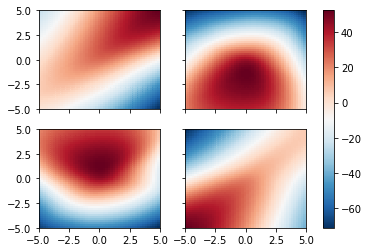

In [62]:
d = 2
DEVICE = "cuda"
f, axs = plt.subplots(nrows=d,ncols=d,sharex=True, sharey=True)
for i in range(d):
    for j in range(d):
        im = plot_subfigure(discriminator, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)
f.colorbar(im, ax=axs.ravel().tolist())
# plt.savefig(f'results/newresults/NCE_trueref_heatmap_dim{opt.d}_iter{opt.n_epoch}.pdf')
plt.show()

In [248]:
type(f)

matplotlib.figure.Figure

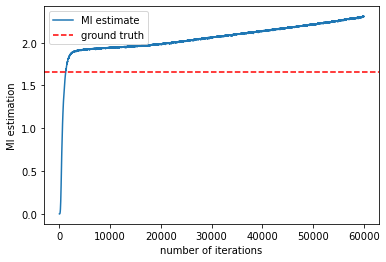

In [170]:
plt.plot(mi_list, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()
# plt.savefig(f'./results/newresults/NCE+NCE_dim{opt.d}')

In [54]:
np.log(np.exp(40)+np.exp(-40))

40.0

In [149]:
mask = torch.ones([3]).diag().unsqueeze(-1).cuda().bool()

In [234]:
x_tile = X.unsqueeze(0).repeat((opt.sample_size, 1, 1))
y_tile = Y.unsqueeze(1).repeat((1, opt.sample_size, 1))

discriminator(XY).mean()

tensor(-1040.1290, grad_fn=<MeanBackward0>)

In [157]:
t[~mask].reshape(-1,2,1)

tensor([[[0.5481],
         [0.3228]],

        [[0.4408],
         [0.5289]],

        [[0.3595],
         [0.0747]]])

In [139]:
labels = torch.cat([torch.arange(3) for i in range(1)], dim=0)
labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

In [143]:
labels.shape

torch.Size([3, 3])

In [136]:
mask = torch.eye(labels.shape[0], dtype=torch.bool)

In [137]:
mask

tensor([[ True, False],
        [False,  True]])

In [138]:
labels[~mask].view(labels.shape[0], -1)

tensor([[0.],
        [0.]])

In [94]:
int(str(math.pi)[-1])

3